# CP6  Aprendizaje de Máquinas
---
## Algoritmos de Clustering: K-Means y DBSCAN

En esta clase práctica, exploramos cómo funcionan *K-means* y *DBSCAN*. Además, mostramos varios problemas de *K-means* y brindamos soluciones para abordar esos problemas, incluido el análisis de calidad de clúster.

In [25]:
# Start from importing necessary packages.
import warnings
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from IPython.display import display
from sklearn import metrics # for evaluations
from sklearn.datasets import make_blobs, make_circles # for generating experimental data
from sklearn.preprocessing import StandardScaler # for feature scaling
from sklearn.cluster import KMeans 
from sklearn.cluster import DBSCAN

# make matplotlib plot inline (Only in Ipython).
warnings.filterwarnings('ignore')
%matplotlib inline

### Ejercicio 1: Análisis del dataset

In [26]:
# Generando datos.
# `random_state` es la semilla utilizada por el generador de números aleatorios (random number generator) para la reproducibilidad (default=None).
X, y = make_blobs(n_samples=5000,
                  n_features=2,
                  centers=3,
                  random_state=170)

In [27]:
X

array([[-4.01009423, -1.01473496],
       [ 1.00550526,  0.13163222],
       [ 2.06563121, -0.24527689],
       ...,
       [-5.09493013,  1.47160372],
       [-9.61459714, -4.91848716],
       [-7.72675795, -5.86656563]])

In [28]:
y

array([1, 2, 2, ..., 1, 0, 0])

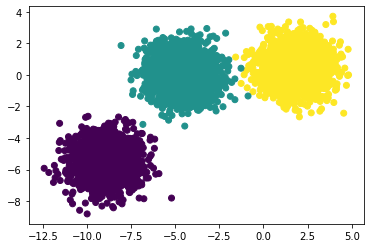

In [29]:
# Grafique la distribución de datos (_ground truth_) usando matplotlib `scatter(axis-x, axis-y, color)`.
plt.scatter(X[:,0], X[:,1], c=y)

### Ejercicio 2: Usando K-Means


### El Algoritmo

1. Elija aleatoriamente $k$ centroides $C = \{c_1, c_2, \dots, c_k\}$ de los puntos de datos $X = \{x_1, x_2, \dots, x_n\} \in \mathbb{R} ^D$.
2. Para cada punto de datos $x_i$, encuentre el centroide más cercano $c_j$ como su grupo correspondiente usando **suma de la distancia al cuadrado** (*sum of squared distance*) $D(x_i, c_j) = \displaystyle\sum_{i=1}^{n}{ \| x_i - c_j \|^2}$.
3. Para cada grupo, actualice su centroide calculando el valor medio a lo largo de la dimensión de los puntos de datos en el grupo.
4. Calcule el desplazamiento entre los centroides antiguo y nuevo y repita los pasos 2 y 3 si el desplazamiento es menor que un umbral (convergente).

In [30]:
""" K-means clustering algorithm.

Parameters
----------
n_init: int, optional, default: 10
        Number of time the k-means algorithm will be run with different
        centroid seeds. The final results will be the best output of
        n_init consecutive runs in terms of inertia.
        
init: {'k-means++', 'random', or ndarray, or a callable}, optional
        Method for initialization, default to 'k-means++'.
        
        'k-means++': selects initial cluster centers for k-mean
        clustering in a smart way to speed up convergence.
        
        'random': generate k centroids from a Gaussian with mean and
        variance estimated from the data.

tol: float, default: 1e-4
        Relative tolerance with regards to inertia to declare convergence
        tolerance is computed using `np.mean(np.var(X, axis=0)) * tol)`

"""
# Perform K-means on our data (Train centroids)
kmeans = KMeans(n_clusters=3,
                n_init=3,
                init='random',
                tol=1e-4, 
                random_state=170,
                verbose=True).fit(X)

Initialization complete
Iteration 0, inertia 93044.04597983109
Iteration 1, inertia 11941.891546455787
Iteration 2, inertia 9733.270749140662
Converged at iteration 2: center shift 6.990341405571933e-05 within tolerance 0.0014634111435935595.
Initialization complete
Iteration 0, inertia 49491.22189277588
Iteration 1, inertia 43229.84746448647
Iteration 2, inertia 42926.506753877606
Iteration 3, inertia 42574.50264772276
Iteration 4, inertia 41999.15634451148
Iteration 5, inertia 39853.96747003667
Iteration 6, inertia 28163.261111913802
Iteration 7, inertia 11338.224620471008
Iteration 8, inertia 9733.782646928312
Converged at iteration 8: center shift 0.0003771105416838659 within tolerance 0.0014634111435935595.
Initialization complete
Iteration 0, inertia 35757.30266790043
Iteration 1, inertia 10003.823957399833
Iteration 2, inertia 9733.154277459325
Converged at iteration 2: strict convergence.


In [31]:
# Mostrar predicciones
kmeans.labels_

array([0, 2, 2, ..., 0, 1, 1], dtype=int32)

In [32]:
# Mostrar centros de clusters (centroides)
kmeans.cluster_centers_

array([[-4.55676387,  0.04603707],
       [-8.94710203, -5.51613184],
       [ 1.89450492,  0.5009336 ]])

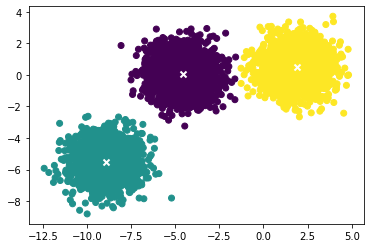

In [33]:
# Graficar las predicciones
plt.scatter(X[:,0], X[:,1], c=kmeans.labels_)
plt.scatter(kmeans.cluster_centers_[:,0], 
            kmeans.cluster_centers_[:,1], 
            c='w', marker='x', linewidths=2)

In [34]:
# Podemos hacer nuevas predicciones sin volver a ejecutar kmeans (simplemente encuentre los centroides más cercanos).
X_new = np.array([[10,10], [-10, -10], [-5, 10]])
y_pred = kmeans.predict(X_new)

""" El siguiente código es equivalente a:
y_pred = KMeans(...).fit_predict(X), pero esto necesita realizar `fit` nuevamente.
"""

y_pred

array([2, 1, 0], dtype=int32)

In [35]:
# Podemos obtener distancias desde el punto de datos hasta cada centroide

"""El siguiente código es equivalente a:
from sklearn.metrics.pairwise import euclidean_distances
euclidean_distances(X_new, kmeans.cluster_centers_)
"""

kmeans.transform(X_new)

array([[17.63464636, 24.48965134, 12.48724601],
       [11.42592142,  4.60582976, 15.86659553],
       [ 9.96382639, 16.01030799, 11.73739582]])

### Ejercicio 3: Una forma más inteligente de inicializar centroides: K-means++

Dado que *K-means* depende en gran medida de la inicialización de los centroides, los resultados de la agrupación pueden converger a un mínimo local. Podemos abordar esto configurando `init='kmeans++'` en lugar de `'random'`. *K-means++* inicializa los centroides de una forma más inteligente para acelerar la convergencia. El algoritmo es como sigue:
1. Elija al azar un centroide de los puntos de datos.
2. Para cada punto de datos $x_i$, calcule la distancia $D(x_i, c_j)$ donde $c_j$ es el más cercano a $x_i$.
3. Elija al azar un nuevo punto de datos como un nuevo centroide utilizando *distribución de probabilidad ponderada* proporcional a $D(x_i, c_j)^2$.
4. Repita los pasos 2 y 3 hasta que se hayan elegido los centroides $k$.
5. Ahora que hemos inicializado los centroides, ejecute el algoritmo *K-means*.

In [36]:
# Perform K-means++ on our data.
kmeans_plus_plus = KMeans(n_clusters=3,
                n_init=3,
                init='k-means++',
                tol=1e-4, 
                random_state=170,
                verbose=True).fit(X)

Initialization complete
Iteration 0, inertia 14504.163838606197
Iteration 1, inertia 9735.744827760533
Iteration 2, inertia 9733.167635199436
Converged at iteration 2: center shift 8.017874814659377e-06 within tolerance 0.0014634111435935595.
Initialization complete
Iteration 0, inertia 10751.00184893979
Iteration 1, inertia 9733.461965137216
Converged at iteration 1: center shift 0.00012717967226942724 within tolerance 0.0014634111435935595.
Initialization complete
Iteration 0, inertia 12316.398205045833
Iteration 1, inertia 9733.520322362503
Converged at iteration 1: center shift 0.00016219913816602042 within tolerance 0.0014634111435935595.


Puede ver que *K-means++* converge mucho más rápido que *K-means*!.

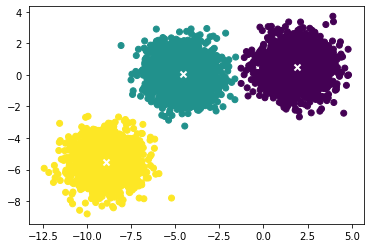

In [37]:
# Graficar las predicciones.
plt.scatter(X[:,0], X[:,1], c=kmeans_plus_plus.labels_)
plt.scatter(kmeans_plus_plus.cluster_centers_[:,0], 
            kmeans_plus_plus.cluster_centers_[:,1], 
            c='w', marker='x', linewidths=2)

### Ejercicio 4: Desventajas de K-means

#### Desventaja 1: Necesita elegir un número correcto de clústeres

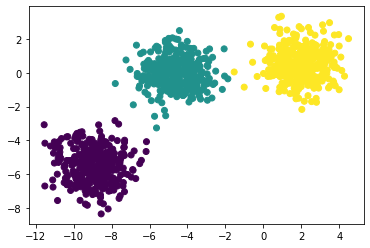

In [38]:
# Generar los datos.
X, y = make_blobs(n_samples=1000,
                  n_features=2,
                  centers=3,
                  random_state=170)

# Graficar la distribución.
plt.scatter(X[:,0], X[:,1], c=y)

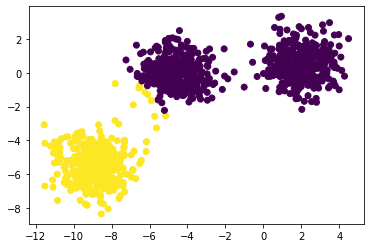

In [39]:
# Ejecute k-means en datos no esféricos.
y_pred = KMeans(n_clusters=2, random_state=170).fit_predict(X)

# Graficar las predicciones.
plt.scatter(X[:,0], X[:,1], c=y_pred)

#### Solución: medir la calidad de los conglomerados para determinar el número de conglomerados


##### Método supervisado
*Homogeneidad*: cada grupo contiene solo miembros de una sola clase.

*Integridad*: Todos los miembros de una clase determinada se asignan al mismo grupo.

##### Método no supervisado

**Coeficiente de Sihouette** (*Sihouette Coefficient*): Evalúa qué tan bien están la **compacidad** y la **separación** de los cúmulos.
(Tenga en cuenta que la notación a continuación es consistente con el contenido anterior). Usando *Coeficiente de Sihouette*, podemos elegir un valor óptimo para el número de grupos.

***

$ a(x_i) $ denota la **distancia media dentro del grupo**. Evalúe la compacidad del clúster al que pertenece $x_i$. (Cuanto más pequeño, más compacto)

$$ a(x_i) = \frac{ \sum_{x_k \in C_j ,\ k \neq i}{D(x_i, x_k)} }{\left\vert C_j \right\vert - 1} $$

Para el punto de datos $x_i$, calcule su distancia promedio a todos los demás puntos de datos en su grupo. (Menos uno en la parte del denominador es omitir el punto de datos actual $x_i$)

***

$ b(x_i) $ denota la **distancia media del cúmulo más cercano**. Evalúe cómo se separa $x_i$ de otros clústeres. (Cuanto más grande más separados)

$$ b(x_i) = \min_{C_j :\ 1 \leq j \leq k ,\ x_i \notin C_j} \left\{ \frac{ \sum_{x_k \in C_j}{D(x_i, x_k)} }{\left\vert C_j \right\vert } \right\} $$

Para el punto de datos $x_i$ y todos los demás grupos que no contienen $x_i$, calcule su distancia promedio a todos los demás puntos de datos en los grupos dados. Encuentre el valor de distancia mínima con respecto a los grupos dados.

***

Finalmente, *Coeficiente de Sihouette*:  $s(x_i) = \displaystyle\frac{b(x_i) - a(x_i)}{\max\{a(x_i), b(x_i)\}},\ -1 \leq s(x_i) \leq 1 $. Se quiere $a(x_i) \lt b(x_i)$ y $a(x_i) \to 0$ así como $s(x_i) \to 1$.

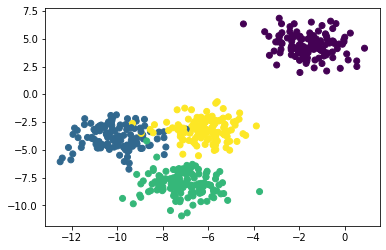

In [40]:
# Generar los datos.
# Esta configuración particular tiene un grupo distinto y 3 grupos colocados muy juntos.
X, y = make_blobs(n_samples=500,
                  n_features=2,
                  centers=4,
                  cluster_std=1,
                  center_box=(-10.0, 10.0),
                  shuffle=True,
                  random_state=1)

# Graficar la distribución de los datos.
plt.scatter(X[:,0], X[:,1], c=y)

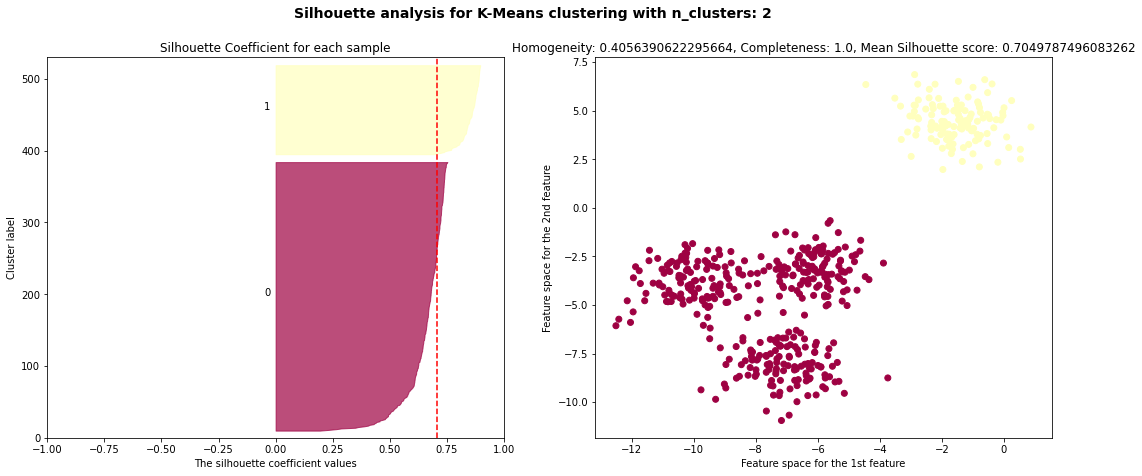

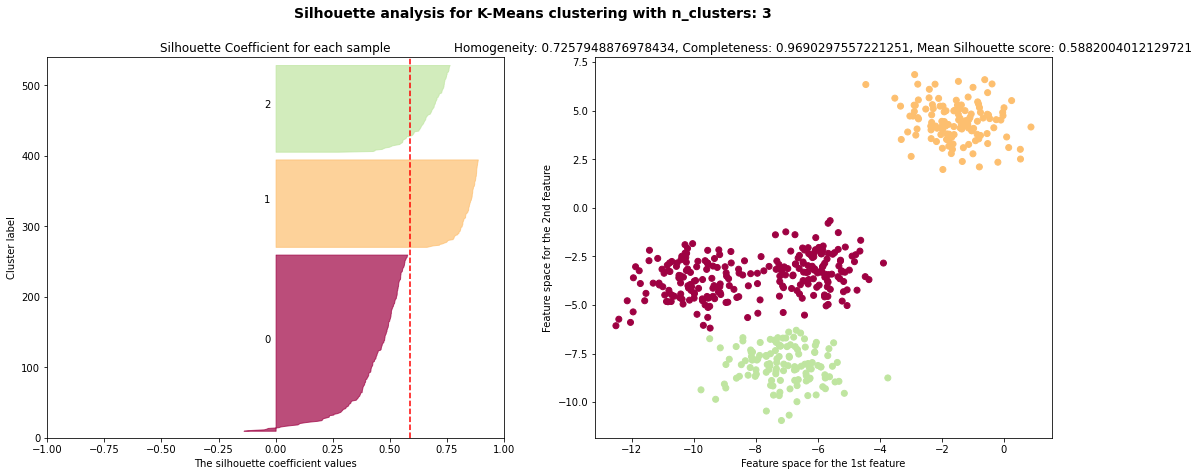

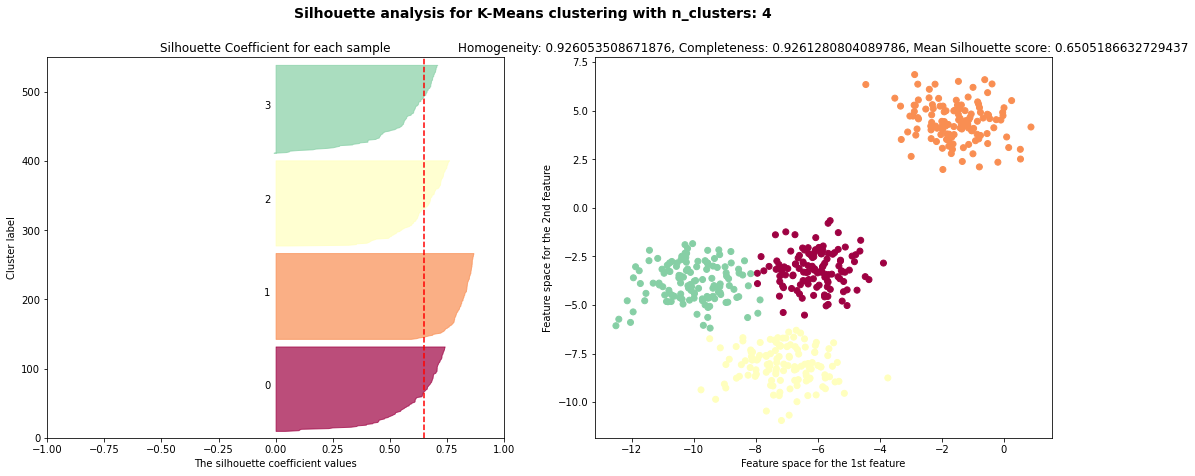

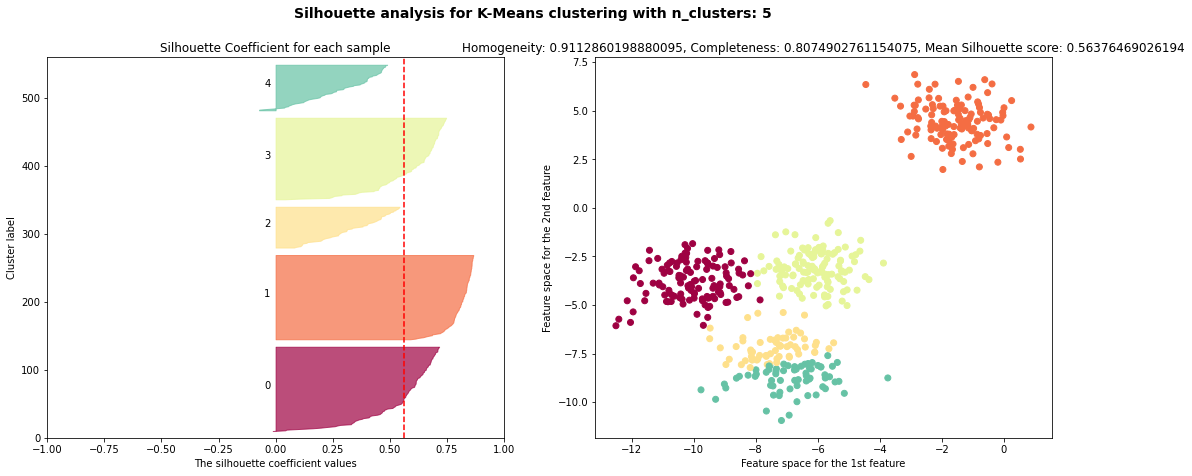

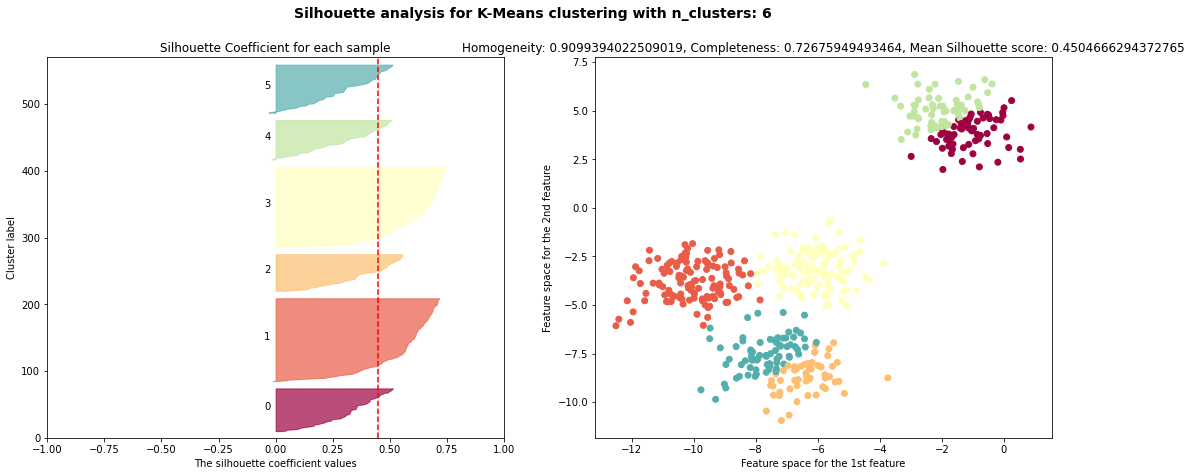

In [43]:
# Lista de número de clústeres
range_n_clusters = [2, 3, 4, 5, 6]

# Para cada número de conglomerados, realice un análisis de Silhouette y visualice los resultados.
for n_clusters in range_n_clusters:
    
    # Realizar k-means.
    kmeans = KMeans(n_clusters=n_clusters, random_state=10)
    y_pred = kmeans.fit_predict(X)
    
    # Calcular la homogeneidad y la integridad de los clusteres.
    homogeneity = metrics.homogeneity_score(y, y_pred)
    completeness = metrics.completeness_score(y, y_pred)
    
    # Calcular el coeficiente de coeficiente de Silhouette para cada muestra.
    s = metrics.silhouette_samples(X, y_pred)
    
    # Calcule el coeficiente de Silhouette medio de todos los puntos de datos.
    s_mean = metrics.silhouette_score(X, y_pred)
    
    # For plot configuration -----------------------------------------------------------------------------------
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    
    # Configure plot.
    plt.suptitle('Silhouette analysis for K-Means clustering with n_clusters: {}'.format(n_clusters),
                 fontsize=14, fontweight='bold')
    
    # Configure 1st subplot.
    ax1.set_title('Silhouette Coefficient for each sample')
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.set_xlim([-1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    
    # Configure 2st subplot.
    ax2.set_title('Homogeneity: {}, Completeness: {}, Mean Silhouette score: {}'.format(homogeneity,
                                                                                        completeness,
                                                                                        s_mean))
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")
    
    # For 1st subplot ------------------------------------------------------------------------------------------
    
    # Plot Silhouette Coefficient for each sample
    cmap = cm.get_cmap("Spectral")
    y_lower = 10
    for i in range(n_clusters):
        ith_s = s[y_pred == i]
        ith_s.sort()
        size_cluster_i = ith_s.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cmap(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_s,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10
        
    # Plot the mean Silhouette Coefficient using red vertical dash line.
    ax1.axvline(x=s_mean, color="red", linestyle="--")
    
    # For 2st subplot -------------------------------------------------------------------------------------------
    
    # Plot the predictions
    colors = cmap(y_pred.astype(float) / n_clusters)
    ax2.scatter(X[:,0], X[:,1], c=colors)

El gráfico de silueta muestra que el valor `n_clusters` de 3, 5 y 6 es una mala elección para los datos dados debido a la presencia de clústeres con puntajes de silueta por encima del promedio y también debido a las amplias fluctuaciones en el tamaño de los gráficos de silueta. El análisis de la silueta es más ambivalente al decidir entre 2 y 4.

### Drawback 2: Cannot handle noise data and outliers

Even noise data and outliers are easily observed from the following clustering results (the data points which are relatively far away from the centroids), *K-means* still puts them into the clusters.

In [1]:
# Generate data.
# This particular setting has one distinct cluster and 3 clusters placed close together.
# (Same as the above example)
X, y = make_blobs(n_samples=500,
                  n_features=2,
                  centers=4,
                  cluster_std=1,
                  center_box=(-10.0, 10.0),
                  shuffle=True,
                  random_state=1)

# Perform k-means with n_clusters=4
kmeans = KMeans(n_clusters=4, random_state=10)
y_pred = kmeans.fit_predict(X)

# Plot the prediction
plt.scatter(X[:,0], X[:,1], c=y_pred)

NameError: name 'make_blobs' is not defined

### Solution: Use Distance Threshold to Detect Noise data and Outliers

However, we can detect the noises/outliers conditioning on whether the distance between the data point $x_i$ and the centroid $c_j$ of $x_i$'s corresponding cluster is larger than the average distance in the cluster. That is to say:

$$
\begin{equation}
  x_i=\left\{
  \begin{array}{ll}
    \text{Outlier}, & \text{if}\ D(x_i, c_j) \gt \frac{1}{\left\vert Cluster_j \right\vert} \sum_{k=0,\ k \neq i}^{\left\vert Cluster_j \right\vert}{D(x_k,c_j)} \\
    \text{Non-outlier}, & \text{otherwise}
  \end{array}\right.
  \text{where } c_j \in Cluster_j
\end{equation}
$$

Let's begin to find out the outliers of each cluster. 

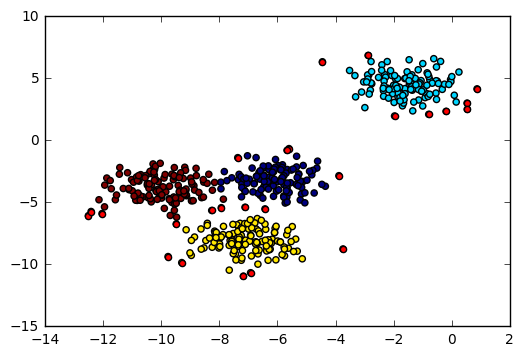

In [ ]:
# Ratio for our distance threshold, controlling how many outliers we want to detect.
distance_threshold_ratio = 2.0

# Plot the prediction same as the above.
plt.scatter(X[:,0], X[:,1], c=y_pred)

# For each ith cluster, i=0~3 (we have 4 clusters in this example).
for i in [0, 1, 2, 3]:
    
    # Retrieve the indexs of data points belong to the ith cluster.
    # Note: `np.where()` wraps indexs in a tuple, thus we retrieve indexs using `tuple[0]`
    indexs_of_X_in_ith_cluster = np.where(y_pred == i)[0]

    # Retrieve the data points by the indexs
    X_in_ith_cluster = X[indexs_of_X_in_ith_cluster]
    
    # Retrieve the centroid.
    centroid = kmeans.cluster_centers_[i]
    
    # Compute distances between data points and the centroid.
    # Same as: np.sqrt(np.sum(np.square(X_in_ith_cluster - centroid), axis=1))
    # Note: distances.shape = (X_in_ith_cluster.shape[0], 1). A 2-D matrix.
    distances = metrics.pairwise.euclidean_distances(X_in_ith_cluster, centroid)
    
    # Compute the mean distance for ith cluster as our distance threshold.
    distance_threshold = np.mean(distances)
    
    # Retrieve the indexs of outliers in ith cluster
    # Note: distances.flatten() flattens 2-D matrix to vector, in order to compare with scalar `distance_threshold`.
    indexs_of_outlier = np.where(distances.flatten() > distance_threshold * distance_threshold_ratio)[0]
    
    # Retrieve outliers in ith cluster by the indexs
    outliers = X_in_ith_cluster[indexs_of_outlier]
    
    # Plot the outliers in ith cluster.
    plt.scatter(outliers[:,0], outliers[:,1], c='r')

As we've mentioned about measuring cluster quality analysis, you can run different settings of `distance_threshold_ratio` to find out the best cluster quality.

### Drawback 3: Cannot handle non-spherical data

> *K-means* clustering aims to partition n observations into k clusters in which each observation belongs to the cluster with **the nearest mean**. (Wikipedia) 

Since the concentric circles would have the approximately same mean, so k-means is not suitable to separate them.

Let's generate non-spherical data and plot the ground truths of clusters.

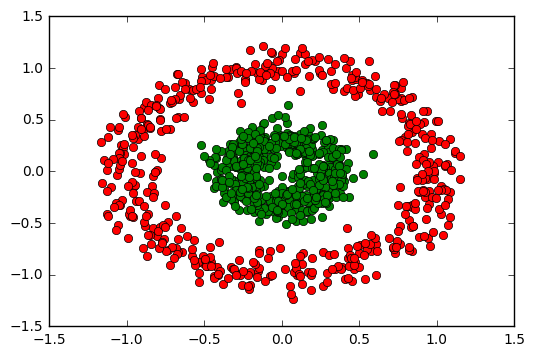

In [24]:
# Generate non-spherical data.
X, y = make_circles(n_samples=1000, factor=0.3, noise=0.1)

# Plot the data distribution. (Here's another way to plot scatter graph)
plt.plot(X[y == 0, 0], X[y == 0, 1], 'ro')
plt.plot(X[y == 1, 0], X[y == 1, 1], 'go')

After performing *K-means* on non-spherical data, the following result shows that it fails to cluster non-spherical data, since *K-means* has an assumption that the data distribution is spherical.

Homogeneity: 0.000488720595137
Completeness: 0.000489467968727
Mean Silhouette score: 0.301354157482


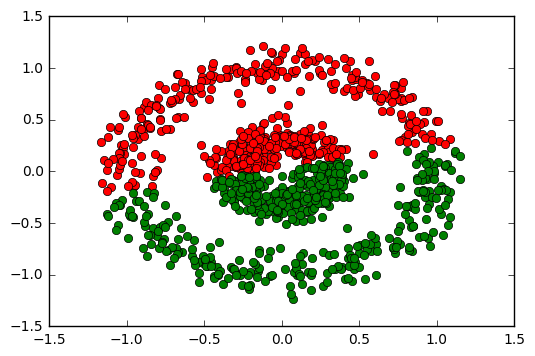

In [33]:
# Run k-means on non-spherical data.
y_pred = KMeans(n_clusters=2, random_state=170).fit_predict(X)

# Plot the predictions.
plt.plot(X[y_pred == 0, 0], X[y_pred == 0, 1], 'ro')
plt.plot(X[y_pred == 1, 0], X[y_pred == 1, 1], 'go')

# Print the evaluations
print('Homogeneity: {}'.format(metrics.homogeneity_score(y, y_pred)))
print('Completeness: {}'.format(metrics.completeness_score(y, y_pred)))
print('Mean Silhouette score: {}'.format(metrics.silhouette_score(X, y_pred)))

### Solution: Using Feature Transformation or Extraction Techiques Makes Data Clusterable

If you know that your clusters will always be concentric circles, you can simply convert your cartesian (x-y) coordinates to polar coordinates, and use only the radius for clustering - as you know that the angle theta doesn't matter.

Or more generally: use a suitable kernel for k-means clustering, e.g. use *Kernel PCA* to find a projection of the data that makes data linearly separable, or use another clustering algorithm, such as *DBSCAN*.

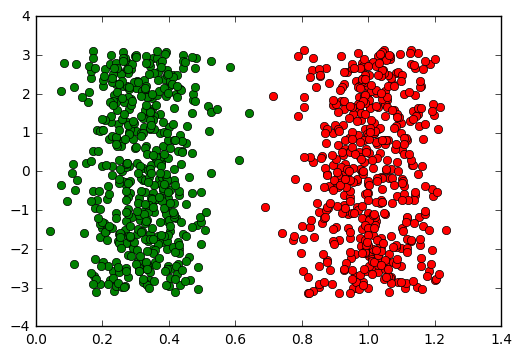

In [38]:
def cart2pol(x, y):
    radius = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)
    return radius, theta

X_transformed = np.zeros_like(X)
X_transformed[:,0], X_transformed[:,1] = cart2pol(X[:,0], X[:,1])

plt.plot(X_transformed[y == 0, 0], X_transformed[y == 0, 1], 'ro')
plt.plot(X_transformed[y == 1, 0], X_transformed[y == 1, 1], 'go')

We just successfully make data linearly separable by converting features (x-y) to (radius-theta) !

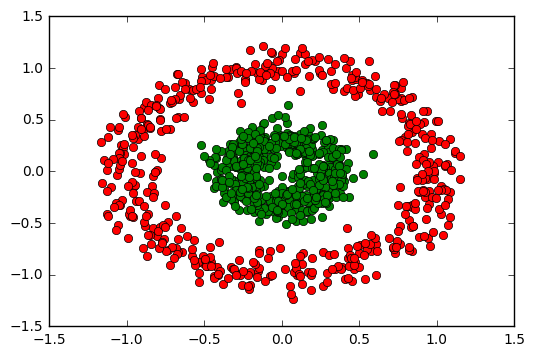

In [39]:
def cart2pol(x, y):
    radius = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)
    return radius, theta

X_transformed = np.zeros_like(X)
# Convert cartesian (x-y) to polar coordinates.
X_transformed[:,0], _ = cart2pol(X[:,0], X[:,1])

# Only use `radius` feature to cluster.
y_pred = KMeans(n_clusters=2).fit_predict(X_transformed)

plt.plot(X[y_pred == 0, 0], X[y_pred == 0, 1], 'ro')
plt.plot(X[y_pred == 1, 0], X[y_pred == 1, 1], 'go')

Now the data is successfully clustered!

### Drawback 4: Cannot to handle categorical data.
Since *k-means* only works when *mean* is defined, categorical data cannot compute mean value.

### Solution: Please refer to https://github.com/nicodv/kmodes

## DBSCAN: Density-Based Spatial Clustering of Applications with Noise

### Parameters
- $Eps$: Maximum radius of the neighborhood.
- $MinPts$: Minimum number of points in the Eps-neighborhood of a point.

### Terms
- The Eps-neighborhood of a point $q$－$N_{Eps}$: A point $p \in N_{Eps}(q)$ if $D(p,q) \leq Eps$. (Point inside the circle).
- Outlier: Not in a cluster.
- Core point: $\left\vert N_{Eps}(q) \right\vert \geq MinPts$ (dense neighborhood).
- Border point: In cluster but neighborhood is not dense.

<div style="text-align:center"><img width="300px" src="../img/core-border-point.png"/></div>


- Directly density-reachable: A point $p$ is **directly density-reachable** from a point $q$ w.r.t $Eps$ and $MinPts$ if:
    - $p \in N_{Eps}(q)$, and $q$ is a **core point**.
    - $p$ **doesn't** need to be a core point.

<div style="text-align:center"><img width="250px" src="../img/directly-density-reachable.png"/></div>

- Density-reachable: A point $p$ is **density-reachable** from a point $q$ w.r.t. $Eps$ and $MinPts$ if there is a chain of points $p_1, \dots, p_n,\ p_1 = q,\ p_n = p$ such that $p_{i+1}$ is directly density-reachable from $p_i$.

<div style="text-align:center"><img width="150px" src="../img/density-reachable.png"/></div>

### The Algorithm
1. Randomly choose a point $p$.
2. Retrieve all points density-reachable from $p$ w.r.t. $Eps$ and $MinPts$.
3. If $p$ is a core point, a cluster is formed.
4. If $p$ is a border point, no points are density-reachable from $p$, then visit the next point.
5. Repeat the process until all the data points have been processed.

Let's begin to perform *DBSCAN* on spherical data

Number of clusters: 3
Homogeneity: 0.982039796605
Completeness: 0.93781096194
Mean Silhouette score: 0.679854880541


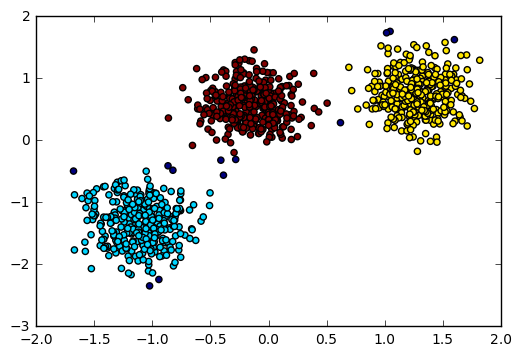

In [20]:
# Generate data with 3 centers.
X, y = make_blobs(n_samples=1000, 
                  n_features=2, 
                  centers=3,
                  random_state=170)

# Standardize features to zero mean and unit variance.
X = StandardScaler().fit_transform(X)

# Perform DBSCAN on the data
y_pred = DBSCAN(eps=0.3, min_samples=30).fit_predict(X)

# Plot the predictions
plt.scatter(X[:,0], X[:,1], c=y_pred)

# Print the evaluations
print('Number of clusters: {}'.format(len(set(y_pred[np.where(y_pred != -1)]))))
print('Homogeneity: {}'.format(metrics.homogeneity_score(y, y_pred)))
print('Completeness: {}'.format(metrics.completeness_score(y, y_pred)))
print('Mean Silhouette score: {}'.format(metrics.silhouette_score(X, y_pred)))

The **black** data points denote the **outliers** in the above result.

Note that we don't need to specify the number of clusters with *DBSCAN* algorithm. Besides, *DBSCAN* is good at finding out the outliers without requiring some hacks like we did above in *K-means* section. 

Now, let's try *DBSCAN* on non-spherical data.

Number of clusters: 2
Homogeneity: 1.0
Completeness: 0.989700155185
Mean Silhouette score: 0.141134617011


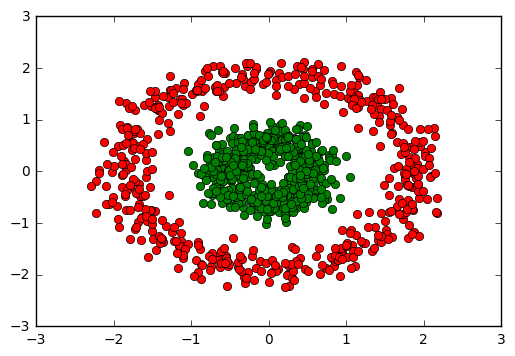

In [21]:
# Generate non-spherical data.
X, y = make_circles(n_samples=1000, factor=0.3, noise=0.1)

# Standardize features to zero mean and unit variance.
X = StandardScaler().fit_transform(X)

# Perform DBSCAN on the data
y_pred = DBSCAN(eps=0.3, min_samples=10).fit_predict(X)

# Plot the data distribution. (Here's another way to plot scatter graph)
plt.plot(X[y_pred == 0, 0], X[y_pred == 0, 1], 'ro')
plt.plot(X[y_pred == 1, 0], X[y_pred == 1, 1], 'go')

# Print the evaluations
print('Number of clusters: {}'.format(len(set(y_pred[np.where(y_pred != -1)]))))
print('Homogeneity: {}'.format(metrics.homogeneity_score(y, y_pred)))
print('Completeness: {}'.format(metrics.completeness_score(y, y_pred)))
print('Mean Silhouette score: {}'.format(metrics.silhouette_score(X, y_pred)))

Comparing to *K-means*, we can directly apply *DBSCAN* on this form of data distribution due to the density-based clustering criterion.

Note: It's worth mention that the *Silhouette score* is generally higher for **convex** clusters than other concepts of clusters, such as density based clusters.

#### References
The tutorial mainly refers to the following resources:
- [scikit-learn](http://scikit-learn.org/)
- [How to understand the drawbacks of K-means](http://stats.stackexchange.com/questions/133656/how-to-understand-the-drawbacks-of-k-means)
- [The Sihouette Coefficient](https://cs.fit.edu/~pkc/classes/ml-internet/silhouette.pdf)
- [Cluster Analysis in Data Mining tutorial video series](https://www.youtube.com/watch?v=uRwzqDeAwfk&index=42&list=PL04RENt_K5EvbBl9rJEy-7D-IAFqPYrMt)
- [DBSCAN](https://en.wikipedia.org/wiki/DBSCAN)